# Código para simular limpiar un salón de N x M

**Integrantes**
- A01800766: Jan Francisco Cerón García
- A01800182: Daniel Alvarez Sil

## 1. Importar librerías.

In [66]:
import numpy as np
import pandas as pd

import mesa

from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle


## 2. Funciones auxiliares.

In [67]:
def percent_clean(model):
    total = model.width * model.height
    return 100.0 * (total - model.dirty_cells) / total


def total_moves(model):
    return model.total_moves


def all_clean(model):
    return model.dirty_cells == 0

## 3. Agente. 

In [68]:
class CleaningAgent(CellAgent):
    """A cleaning agent that cleans its current cell if dirty, else moves randomly."""

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell
        self.moves = 0

    def clean_here(self):
        if getattr(self.cell, "is_dirty", False):
            self.cell.is_dirty = False
            self.model.dirty_cells -= 1

    def random_move(self):
        next_cell = self.cell.neighborhood.select_random_cell()
        if next_cell is not None and next_cell is not self.cell:
            self.cell = next_cell
            self.moves += 1
            self.model.total_moves += 1

    def step(self):
        if getattr(self.cell, "is_dirty", False):
            self.clean_here()
        else:
            self.random_move()


## 4. Modelo. 

In [69]:
class CleaningModel(mesa.Model):
    """
    Room MxN with a percentage of dirty cells.
    All agents start at [1,1] (1-based indexing as requested).
    """

    def __init__(
        self,
        n_agents=3,
        width=12,
        height=12,
        dirty_pct=30.0,
        max_time=200,
        seed=None,
    ):
        super().__init__(seed=seed)
        self.width = width
        self.height = height
        self.n_agents = n_agents
        self.dirty_pct = float(dirty_pct)
        self.max_time = int(max_time)

        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Initialize dirty cells
        total_cells = width * height
        n_dirty = int(round(total_cells * self.dirty_pct / 100.0))
        for cell in self.random.sample(self.grid.all_cells.cells, k=n_dirty):
            cell.is_dirty = True
        for cell in self.grid.all_cells.cells:
            if not hasattr(cell, "is_dirty"):
                cell.is_dirty = False

        self.dirty_cells = n_dirty
        self.time = 0
        self.total_moves = 0
        self.time_to_clean = None

        # Start at [1,1] (1-based); fallback to 0-based if needed
        start_x, start_y = 1, 1
        try:
            start_cell = self.grid[(start_x, start_y)]
        except Exception:
            start_cell = self.grid[(start_x - 1, start_y - 1)]

        # Create agents at same starting cell
        CleaningAgent.create_agents(self, n_agents, [start_cell] * n_agents)

        # Data collection
        self.datacollector = mesa.DataCollector(
        model_reporters={
            "PercentClean": percent_clean,                 # function(model) -> float
            "DirtyCells":   lambda m: m.dirty_cells,       # callable
            "Time":         lambda m: m.time,              # callable (NOT m.time)
            "TotalMoves":   lambda m: m.total_moves,       # callable
            "AllClean":     lambda m: m.dirty_cells == 0,  # callable
        },
        agent_reporters={"Moves": "moves"},
        )
        self.datacollector.collect(self)


    def step(self):
        if self.time >= self.max_time:
            return

        self.agents.shuffle_do("step")
        self.time += 1

        if self.dirty_cells == 0 and self.time_to_clean is None:
            self.time_to_clean = self.time

        self.datacollector.collect(self)

    def run_until_done(self):
        while self.time < self.max_time and self.dirty_cells > 0:
            self.step()

## 5. Visualización. 

In [70]:
# def agent_portrayal(agent):
#     # Auto-scale agent size so it looks good on different grid sizes
#     grid_area = agent.model.width * agent.model.height
#     base = 38 if grid_area <= 12 * 12 else 28 if grid_area <= 20 * 20 else 22
#     return AgentPortrayalStyle(
#         color="tab:blue",
#         size=base,
#         marker="o",   # optional: "o", "^", "s", "*", etc.
#         alpha=1.0     # optional transparency
#     )

# def cell_color(model, cell):
#     # called for every grid cell
#     return "lightcoral" if getattr(cell, "is_dirty", False) else "whitesmoke"

# # Interactive parameters
# model_params = {
#     "n_agents": {
#         "type": "SliderInt",
#         "value": 3,
#         "label": "Number of agents:",
#         "min": 1,
#         "max": 60,
#         "step": 1,
#     },
#     "width": {
#         "type": "SliderInt",
#         "value": 12,
#         "label": "Room width (M):",
#         "min": 5,
#         "max": 50,
#         "step": 1,
#     },
#     "height": {
#         "type": "SliderInt",
#         "value": 12,
#         "label": "Room height (N):",
#         "min": 5,
#         "max": 50,
#         "step": 1,
#     },
#     "dirty_pct": {
#         "type": "SliderFloat",
#         "value": 30.0,
#         "label": "Initial dirty cells (%):",
#         "min": 0.0,
#         "max": 100.0,
#         "step": 1.0,
#     },
#     "max_time": {
#         "type": "SliderInt",
#         "value": 200,
#         "label": "Max time steps:",
#         "min": 10,
#         "max": 5000,
#         "step": 10,
#     },
# }

# # Initial model instance (UI will recreate it when sliders change)
# room_model = CleaningModel(n_agents=100, width=12, height=12, dirty_pct=30, max_time=200)

# renderer = SpaceRenderer(model=room_model, backend="matplotlib").render(
#     agent_portrayal=agent_portrayal,
#     cell_color=cell_color,   # <-- now matches expected signature
# )

# # Plots: act as live counters and trends
# TimePlot = make_plot_component("Time", page=1)              # steps elapsed (counter/trend)
# DirtyPlot = make_plot_component("DirtyCells", page=1)       # dirty cells (counter/trend)
# PercentPlot = make_plot_component("PercentClean", page=1)   # cleanliness % (trend)
# MovesPlot = make_plot_component("TotalMoves", page=2)       # moves over time

# page = SolaraViz(
#     room_model,
#     renderer,
#     components=[TimePlot, DirtyPlot, PercentPlot, MovesPlot],
#     model_params=model_params,
#     name="Room Cleaning Model — Dirty Cells Highlighted",
# )

# # Required for Jupyter rendering
# page

## 6. Ejecución de simulaciones. 

,run,agents,time_to_clean,percent_clean_end,total_moves,cleaned_all
0,1,1,5000,30.08,3992,False
1,2,11,5000,67.18,50282,False
2,3,21,5000,88.88,98112,False
3,4,31,5000,95.11,147489,False
4,5,41,5000,97.63,197237,False
5,6,51,5000,92.90,247710,False
6,7,61,5000,95.69,297431,False
7,8,71,5000,99.05,347095,False
8,9,81,5000,98.75,397125,False
9,10,91,5000,99.91,447009,False


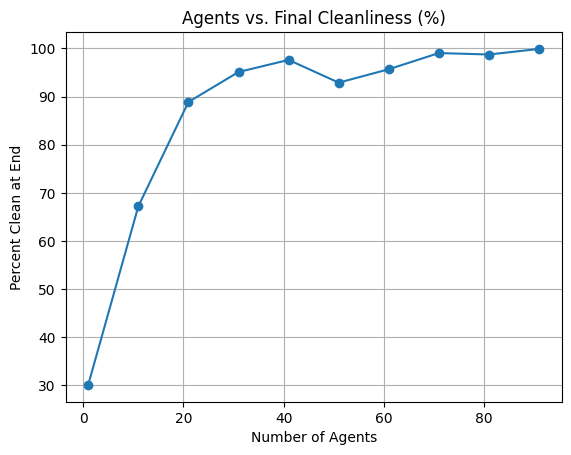

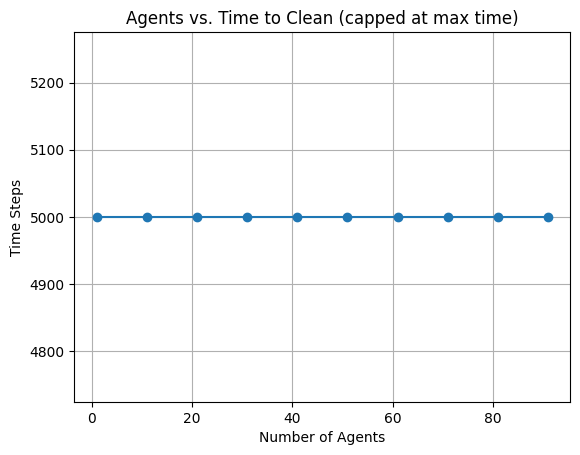

corr(agents, percent_clean_end) = 0.747
corr(agents, time_to_clean)     = nan


In [71]:
# =========================
# Batch runs & notebook display (Mesa-based, no DataCollector needed)
# Paste this AFTER your CleaningModel + percent_clean definitions
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# ---- Experiment configuration
WIDTH, HEIGHT   = 100, 100     # Room size (M x N)
DIRTY_PCT       = 80.0      # Initial dirty cells (%)
MAX_TIME        = 5000      # Max time steps for ALL runs
START_AGENTS    = 1          # Starting number of agents
NUM_RUNS        = 10         # Will run agents = 1..10

agent_counts = list(range(START_AGENTS, START_AGENTS + NUM_RUNS * 10, 10))

# ---- Run experiments
rng = np.random.RandomState(2025)  # reproducible seeds per run
rows = []
for i, k in enumerate(agent_counts, start=1):
    seed = int(rng.randint(0, 2**31 - 1))
    model = CleaningModel(
        n_agents=k,
        width=WIDTH,
        height=HEIGHT,
        dirty_pct=DIRTY_PCT,
        max_time=MAX_TIME,
        seed=None,
    )
    model.run_until_done()

    time_needed = model.time_to_clean if model.time_to_clean is not None else MAX_TIME
    pct_clean   = percent_clean(model)  # uses your helper
    total_moves = model.total_moves

    rows.append(
        {
            "run": i,
            "agents": k,
            "time_to_clean": time_needed,
            "percent_clean_end": pct_clean,
            "total_moves": total_moves,
            "cleaned_all": model.dirty_cells == 0,
        }
    )

results_df = pd.DataFrame(rows)

# ---- Display table
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
display(results_df)

# ---- Charts
# Agents vs Percent Clean
plt.figure()
plt.plot(results_df["agents"], results_df["percent_clean_end"], marker="o")
plt.title("Agents vs. Final Cleanliness (%)")
plt.xlabel("Number of Agents")
plt.ylabel("Percent Clean at End")
plt.grid(True)
plt.show()

# Agents vs Time to Clean (capped at MAX_TIME if not fully cleaned)
plt.figure()
plt.plot(results_df["agents"], results_df["time_to_clean"], marker="o")
plt.title("Agents vs. Time to Clean (capped at max time)")
plt.xlabel("Number of Agents")
plt.ylabel("Time Steps")
plt.grid(True)
plt.show()

# ---- Quick correlation readout
corr_agents_pct  = results_df[["agents", "percent_clean_end"]].corr().iloc[0, 1]
corr_agents_time = results_df[["agents", "time_to_clean"]].corr().iloc[0, 1]
print(f"corr(agents, percent_clean_end) = {corr_agents_pct:.3f}")
print(f"corr(agents, time_to_clean)     = {corr_agents_time:.3f}")
